In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DKL/MC_dropout/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/DKL/MC_dropout


#### Monte carlo dropout for Air Quality dataset

### Read libraries

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
import itertools
import pandas as pd

torch.manual_seed(42)
np.random.seed(42)

In [20]:
import pandas as pd
import numpy as np
import os
import torch
import torch.optim as optim
from features import feature_prep, feature_prep_air_quality, inverse_transform, format_predictions, calculate_metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### Read data and split dataset into train, val and test set

In [3]:
df = pd.read_excel('AirQualityUCI.xlsx')
df['hour'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.hour
df['month'] = pd.DatetimeIndex(df['Date']).month


In [4]:
batch_size = 256
X_train, y_train, train_features, train_targets, X_test,y_test, scaler, scaler1, train_loader,val_loader, test_loader, train_loader_one, test_loader_one = feature_prep_air_quality(df, batch_size=batch_size)


Identified outliers: 368
Non-outlier observations: 8989


In [5]:
class MLP(nn.Module):
    "MLP model architechture"
    def __init__(self, input_dim=1, output_dim=1, hidden_dim=10, n_hidden_layers=1, use_dropout=False):
        super().__init__()

        self.use_dropout = use_dropout
        if use_dropout:
            self.dropout = nn.Dropout(p=0.5)
        self.activation = nn.Tanh()

        # dynamically define architecture
        self.layer_sizes = [input_dim] + n_hidden_layers * [hidden_dim] + [output_dim]
        layer_list = [nn.Linear(self.layer_sizes[idx - 1], self.layer_sizes[idx]) for idx in
                      range(1, len(self.layer_sizes))]
        self.layers = nn.ModuleList(layer_list)

    def forward(self, input):
        hidden = self.activation(self.layers[0](input))
        for layer in self.layers[1:-1]:
            hidden_temp = self.activation(layer(hidden))

            if self.use_dropout:
                hidden_temp = self.dropout(hidden_temp)

            hidden = hidden_temp + hidden  # residual connection

        output_mean = self.layers[-1](hidden).squeeze()
        return output_mean
class LSTMModel(nn.Module):
    "LSTM model architechture"
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device):

        super(LSTMModel, self).__init__()

        self.device = device
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.activation = nn.Tanh()
        self.dropout = nn.Dropout(p=0.5)
        # LSTM layers

        self.lstm = nn.LSTM(
            input_dim, hidden_dim, layer_dim, batch_first=True, dropout=dropout_prob, bias = True,# bidirectional =True
        )

        self.lstm2 = nn.LSTMCell(self.hidden_dim, self.hidden_dim)
        # Fully connected layer

        self.fc = nn.Linear(hidden_dim, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, output_dim)


    def forward(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device).requires_grad_()
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(self.device).requires_grad_()

        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.activation(out[:, -1, :].to(self.device))
        out = self.dropout(out)
        out = self.fc(out)
        out = self.dropout(out)
        out = self.fc1(out)
        return out



##### Define model hyperparameter

In [6]:
# net_dropout = MLP(input_dim=len(features),hidden_dim=30, n_hidden_layers=2, use_dropout=True)
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 1000
layer_dim = 3
kernel = 1
out_channels = 24

dropout_prob = 0.3968084179060663
n_epochs = 150
learning_rate = 0.001
weight_decay = 1e-6
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net_dropout = LSTMModel(input_dim, hidden_dim, layer_dim, output_dim, dropout_prob, device)
net_dropout = net_dropout.to(device)


### Training code

In [7]:
def train(model, trainloader, num_epochs=20):
    "Training function"
    optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
    criterion = nn.MSELoss()
    epoch_loss = []
    for epoch in range(num_epochs):
        model.train()
        
        batch_loss = []
        optimizer.zero_grad()
        for x_batch, y_batch in train_loader:      
            x_batch = x_batch.view([batch_size, -1, input_dim]).to(device)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            loss = criterion(y_batch, model(x_batch))
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())
        epoch_loss.append(np.mean(batch_loss))
        print('epoch:',epoch, ' loss:', np.mean(batch_loss))
    return epoch_loss


In [8]:
epoch_loss = train(net_dropout, train_loader, 50)

epoch: 0  loss: 1.0663239664974666
epoch: 1  loss: 0.56601292462576
epoch: 2  loss: 0.30239865822451456
epoch: 3  loss: 0.2214757553523495
epoch: 4  loss: 0.10202137904152983
epoch: 5  loss: 0.20933058476519018
epoch: 6  loss: 0.09570316003546828
epoch: 7  loss: 0.1354816962210905
epoch: 8  loss: 0.09822822637146428
epoch: 9  loss: 0.13154160940930956
epoch: 10  loss: 0.23909262230708486
epoch: 11  loss: 0.13925800649892717
epoch: 12  loss: 0.16239097199979283
epoch: 13  loss: 0.10479299857148103
epoch: 14  loss: 0.11987608972759474
epoch: 15  loss: 0.06767642941503298
epoch: 16  loss: 0.11669625678942316
epoch: 17  loss: 0.10691079994042714
epoch: 18  loss: 0.05553750046307132
epoch: 19  loss: 0.10403599221968934
epoch: 20  loss: 0.06892756009030909
epoch: 21  loss: 0.06821009046619847
epoch: 22  loss: 0.032627400143870285
epoch: 23  loss: 0.03859443731960796
epoch: 24  loss: 0.028806567103380247
epoch: 25  loss: 0.025113553030505067
epoch: 26  loss: 0.03173013177833387
epoch: 27  los

#### Visulaize training loss

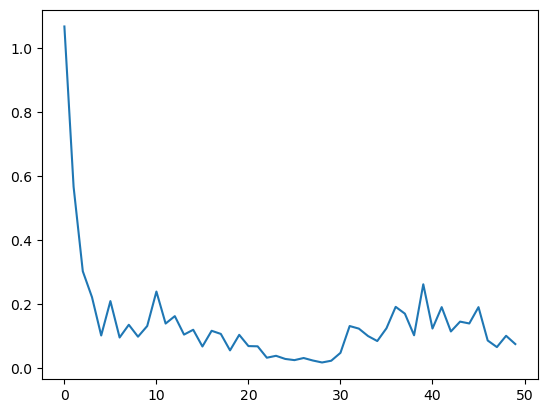

In [9]:
plt.plot(epoch_loss)

### Inference

In [10]:
def enable_dropout(model):
    """ Function to enable the dropout layers during test-time """
    for m in model.modules():
        if m.__class__.__name__.startswith('Dropout'):
            m.train()

In [31]:
n_dropout_samples = 10000

# # compute predictions, resampling dropout mask for each forward pass
# y_preds = [net_dropout(x_test).clone().detach().numpy() for _ in range(n_dropout_samples)]
# y_preds = np.array(y_preds)
y_preds = []
for i in range(n_dropout_samples):
  net_dropout.eval()
  enable_dropout(net_dropout)
  test_pred = []
  if i==0:
    test_actual = []
  with torch.no_grad():
    for x_test, test_y in test_loader:
        x_test = x_test.view([batch_size, -1, input_dim]).to(device)
        y_pred = net_dropout(x_test).clone().detach().cpu()
        test_pred.append(torch.flatten(y_pred).numpy().tolist())
        if i==0:
          test_actual.append(test_y.flatten().tolist())
    y_preds.append(list(itertools.chain.from_iterable(test_pred)))
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [32]:
def inverse_transform(scaler, df, columns):
  for col in columns:
      df[col] = scaler.inverse_transform(df[col])
  return df

In [33]:
df_result = pd.DataFrame(y_preds).T
df_result.columns = ['pred_'+str(i) for i in range(len(y_preds))]
df_result['actual'] = list(itertools.chain.from_iterable(test_actual))
pred_cols = df_result.drop(['actual'], axis=1).columns

In [34]:
df_result = inverse_transform(scaler1, df_result, [list(df_result.columns)])
df_result['std_pred'] = df_result[pred_cols].std(axis=1)
df_result['mean_pred'] = df_result[pred_cols].mean(axis=1)

In [35]:
df_result.to_csv('df_result_air_quality.csv', index=False)

In [36]:
df = df_result

/tmp/ipykernel_1447/1113071265.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


(array([-5.,  0.,  5., 10., 15., 20., 25., 30., 35.]),
 [Text(0, -5.0, '−5'),
  Text(0, 0.0, '0'),
  Text(0, 5.0, '5'),
  Text(0, 10.0, '10'),
  Text(0, 15.0, '15'),
  Text(0, 20.0, '20'),
  Text(0, 25.0, '25'),
  Text(0, 30.0, '30'),
  Text(0, 35.0, '35')])

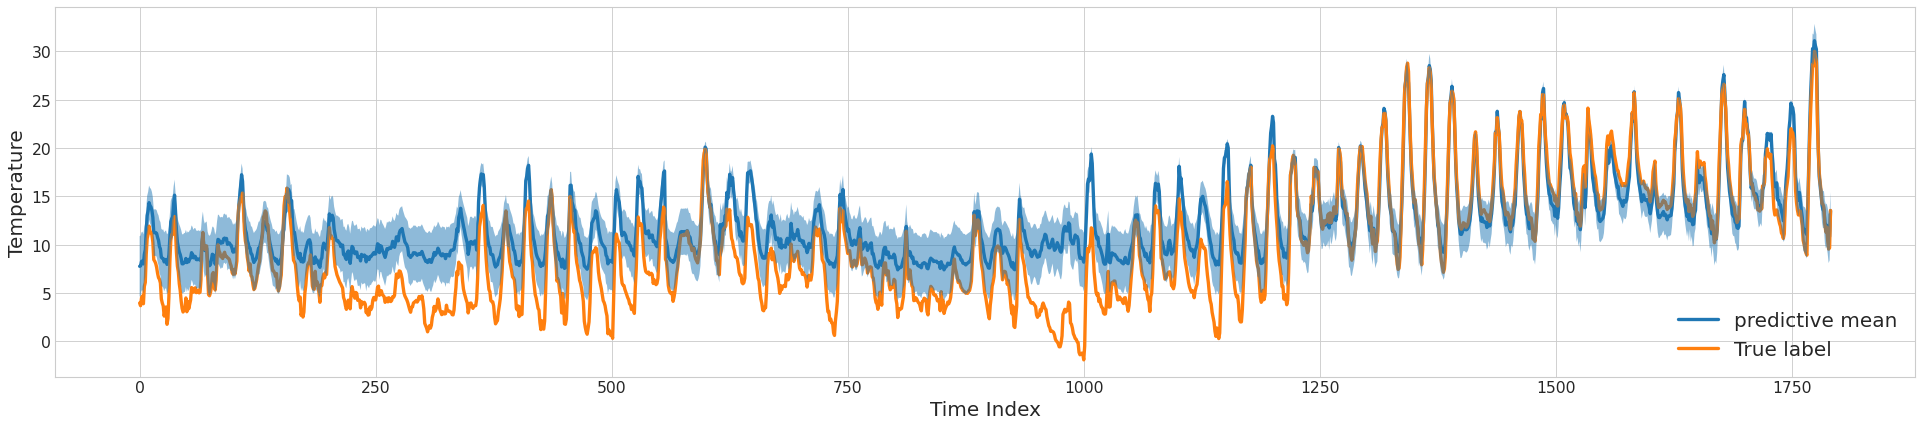

In [37]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.figure(figsize=(30, 6), dpi=80)
y_actual = list(itertools.chain.from_iterable(test_actual))

plt.plot(df.index, df['mean_pred'], '-', linewidth=3, label="predictive mean")
plt.plot(df.index, df['actual'], '-', linewidth=3, label="True label")
plt.fill_between(df.index, df['mean_pred'] - 2 * df['std_pred'], df['mean_pred'] + 2 * df['std_pred'], alpha=0.5, zorder=5)
plt.legend(fontsize=18, loc = 'lower right')
plt.xlabel('Time Index', fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.xticks(fontsize=14, )
plt.yticks(fontsize=14, )


### Error metric

In [38]:
def calculate_metrics(df):

    return {
            'mae' : mean_absolute_error(df.actual, df.mean_pred),
            'mse' : mean_squared_error(df.actual, df.mean_pred) ** 0.5,
            'r2' : r2_score(df.actual, df.mean_pred),
            }
calculate_metrics(df)

{'mae': 2.834872091286722, 'mse': 3.5378610603759277, 'r2': 0.6467110694843252}

In [39]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true))
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)
    
mean_absolute_percentage_error(df.actual, df.mean_pred)

0.18739562930343717